### This is a repeat assignment. I have used the pytreebank package last time to get the SST dataset. Here we will create the dataset on our own.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext.legacy
from torchtext import datasets

import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
import random
import os, pickle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Get the raw data

In [2]:
! wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip

--2021-06-15 16:57:26--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-06-15 16:57:26--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip’

stanfordSentimentTr 100%[===================>]   6.08M  2.14MB/s    in 2.8s    

2021-06-15 16:57:29 (2.14 MB/s) - ‘stanfordSentimentTreebank.zip’ saved [6372817/6372817]



In [3]:
!unzip stanfordSentimentTreebank.zip

Archive:  stanfordSentimentTreebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: __MACOSX/
   creating: __MACOSX/stanfordSentimentTreebank/
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._sentiment_labels.txt  
  inflating: stanfordSentimentTreebank/SOStr.txt  
  inflating: stanfo

## Load Dataset into dataframes

In [4]:
# Get Sentiment Labels
sentiment_labels = pd.read_csv('/content/stanfordSentimentTreebank/sentiment_labels.txt',names=['phrase_id','sentiment_values'], sep = "|", header = 0)

In [5]:
sentiment_labels.head()

,phrase_id,sentiment_values
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708


In [6]:
# Convert label values to 5 buckets
n_bins = 5
sentiment_labels['sentiment_values'] = pd.cut(sentiment_labels['sentiment_values'], n_bins, labels = np.arange(5),retbins=True)[0]
sentiment_labels.head()

,phrase_id,sentiment_values
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2


In [7]:
# Get Sentence Ids
sentence_ids = pd.read_csv('/content/stanfordSentimentTreebank/datasetSentences.txt', sep = "\t")

In [8]:
sentence_ids.head()

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."


In [9]:
# Get Dictionary
dictionary = pd.read_csv('/content/stanfordSentimentTreebank/dictionary.txt', sep = "|", names = ['phrase', 'phrase_id'])

In [10]:
dictionary.head()

,phrase,phrase_id
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936


### In this dataset, each sentence is split into lowest level phrases/tokens and these phrases are proivided the sentiments. These leaf level nodes are merged to get the sentiment of next level and this goes up till the entire sentence. Hence the dictionary contains all sentences with the sentiment as top level phrase or node. We can do an inner join to find these phrases.

In [11]:
sentence_phrase_map = pd.merge(sentence_ids, dictionary, left_on='sentence', right_on='phrase')
sentence_phrase_map.head()

,sentence_index,sentence,phrase,phrase_id
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,13995
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999


### As we need to get the sentiment of the sentences and sentiments are maintained at phrase level, we will do the inner join to get the sentiment of sentences using the df from above step

In [12]:
sentence_sentiment = pd.merge(sentence_phrase_map, sentiment_labels, left_on='phrase_id', right_on='phrase_id')

In [13]:
sentence_sentiment.head()

,sentence_index,sentence,phrase,phrase_id,sentiment_values
0,1,The Rock is destined to be the 21st Century 's...,The Rock is destined to be the 21st Century 's...,226166,3
1,2,The gorgeously elaborate continuation of `` Th...,The gorgeously elaborate continuation of `` Th...,226300,4
2,3,Effective but too-tepid biopic,Effective but too-tepid biopic,13995,2
3,4,If you sometimes like to go to the movies to h...,If you sometimes like to go to the movies to h...,14123,3
4,5,"Emerges as something rare , an issue movie tha...","Emerges as something rare , an issue movie tha...",13999,4


In [14]:
len(sentence_sentiment)

11286

### To get the train test split, we will not use the train_test split dataset which has got the sentence index and split label and instead we will split the data into 70:30 ratio directly

In [15]:
train_set, test_set = train_test_split(sentence_sentiment, test_size= .3, random_state= 42)

In [61]:
train = train_set.drop(['sentence_index','phrase','phrase_id'],axis = 1)
test = test_set.drop(['sentence_index','phrase','phrase_id'],axis = 1)
train.reset_index(drop=True, inplace=True), test.reset_index(drop=True, inplace=True)

(None, None)

In [17]:
len(train), len(test)

(7900, 3386)

In [18]:
train.head()

,sentence,sentiment_values
10633,But ticket-buyers with great expectations will...,0
8877,"Twenty years later , Reggio still knows how to...",2
810,`` 13 Conversations '' holds its goodwill clos...,2
6634,For those of us who respond more strongly to s...,1
8229,Moot point .,1


In [19]:
train['sentiment_values'].value_counts()

1    2077
3    2058
2    1528
4    1219
0    1018
Name: sentiment_values, dtype: int64

[Text(0.5, 0, 'Sentiment Value')]

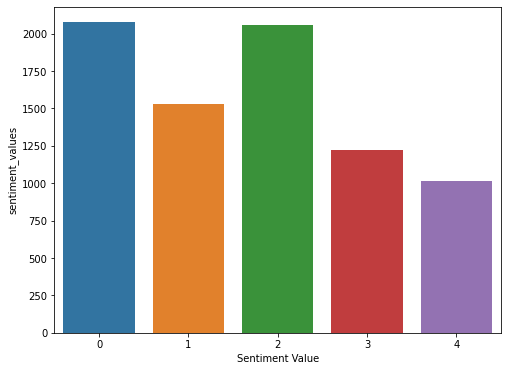

In [20]:
fig = plt.figure(figsize=(8,6))

ax = sns.barplot(x=train['sentiment_values'].unique(), y=train['sentiment_values'].value_counts())

ax.set(xlabel = 'Sentiment Value')

## Tokenize the data

In [21]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [22]:
def text_clean(text):
  text = re.sub(r'[^A-Za-z0-9_-]+', ' ', text)
  text = re.sub(r'https?:/\/\S+', ' ', text)

  return(text.strip())

In [23]:
nlp = spacy.load('en', disable = ['parser', 'tagger', 'ner'])
def tokenizer(s):
  return [w.text.lower() for w in nlp(text_clean(s))]

In [24]:
TEXT = torchtext.legacy.data.Field(tokenize = tokenizer)

LABEL = torchtext.legacy.data.LabelField(dtype = torch.float)

In [25]:
datafields = [('sentence', TEXT), ('sentiment_values', LABEL)]

In [28]:
trn, tst = torchtext.legacy.data.TabularDataset.splits(path='/content/session7',
                                                       train = 'train.csv',
                                                       test = 'test.csv',
                                                       format = 'csv',
                                                       skip_header = True,
                                                       fields = datafields
                                                       )

In [29]:
trn[:5]

In [30]:
print(f'Number of examples in training {len(trn)}')
print(f'Number of examples in test {len(tst)}')

Number of examples in training 7900
Number of examples in test 3386


In [31]:
trn[5].__dict__.keys()

dict_keys(['sentence', 'sentiment_values'])

In [32]:
print(vars(trn[5]))

{'sentence': ['it', 'offers', 'a', 'glimpse', 'of', 'the', 'solomonic', 'decision', 'facing', 'jewish', 'parents', 'in', 'those', 'turbulent', 'times', 'to', 'save', 'their', 'children', 'and', 'yet', 'to', 'lose', 'them'], 'sentiment_values': '3'}


In [33]:
words = [0 + len(t.sentence) for t in trn]

In [34]:
sum(words)

138717

## Create Vocab

In [35]:
TEXT.build_vocab(trn, max_size = 7750,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_,
                 min_freq = 2 )

LABEL.build_vocab(trn) 

.vector_cache/glove.6B.zip: 862MB [02:42, 5.30MB/s]                           
100%|█████████▉| 399577/400000 [00:20<00:00, 19905.33it/s]

In [36]:
print(TEXT.vocab.freqs.most_common(50))

[('the', 6709), ('a', 4840), ('and', 4097), ('of', 4028), ('to', 2841), ('-', 2545), ('s', 2340), ('is', 2329), ('it', 2304), ('that', 1812), ('in', 1755), ('as', 1183), ('but', 1091), ('film', 1041), ('with', 1033), ('this', 963), ('for', 952), ('movie', 923), ('an', 872), ('its', 869), ('you', 780), ('t', 649), ('n', 638), ('be', 626), ('on', 604), ('not', 566), ('by', 553), ('one', 528), ('more', 494), ('are', 486), ('--', 486), ('like', 481), ('at', 476), ('about', 476), ('has', 468), ('from', 455), ('all', 453), ('than', 449), ('have', 431), ('his', 411), ('i', 407), ('so', 383), ('if', 378), ('story', 330), ('or', 323), ('too', 313), ('there', 312), ('up', 304), ('what', 302), ('out', 296)]


In [37]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', 'a', 'and', 'of', 'to', '-', 's', 'is']


In [38]:
print(LABEL.vocab.stoi)

defaultdict(None, {'1': 0, '3': 1, '2': 2, '4': 3, '0': 4})


# Create train and test iterators

In [39]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
                                                                            (trn, tst),
                                                                            batch_size = BATCH_SIZE,
                                                                            sort_key = lambda x: len(x.sentence),
                                                                            sort_within_batch= True, 
                                                                            device = device)

# Define Network

In [40]:
class RNN(nn.Module):
  
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
    
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers,
                      bidirectional = bidirectional, dropout = dropout )
    
    self.fc = nn.Linear(hidden_dim*2, output_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self, text):

    embedded =  self.dropout(self.embedding(text))

    output, hidden = self.rnn(embedded)

    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

    return self.fc(hidden.squeeze(0))

## Set Network Parameters

In [41]:
input_dim = len(TEXT.vocab)

embedding_dim = 100

hidden_dim  = 256

output_dim = 5

num_layers = 2

bidirectional = True

dropout = .3

## Create Model

In [42]:
model = RNN(input_dim, 
            embedding_dim,
            hidden_dim,
            output_dim,
            num_layers,
            bidirectional,
            dropout)

In [43]:
model

RNN(
  (embedding): Embedding(7752, 100)
  (rnn): GRU(100, 256, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## Use the pretrained GloVe embedddings

In [44]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([7752, 100])


In [45]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.5857, -2.5796,  0.8720,  ..., -0.4522, -0.7387, -0.7126],
        [ 0.4719, -0.0941, -0.3891,  ...,  0.7077, -0.3741,  1.9216],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.2654,  0.5014,  0.7789,  ..., -0.0487,  0.0765,  0.2981],
        [ 0.2592,  0.2430,  0.5118,  ..., -0.1500,  0.1554,  0.4434],
        [-0.1209,  0.5292, -0.4785,  ..., -0.5071,  0.8777,  0.2767]])

In [46]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.2654,  0.5014,  0.7789,  ..., -0.0487,  0.0765,  0.2981],
        [ 0.2592,  0.2430,  0.5118,  ..., -0.1500,  0.1554,  0.4434],
        [-0.1209,  0.5292, -0.4785,  ..., -0.5071,  0.8777,  0.2767]])


In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,510,373 trainable parameters


In [49]:
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
criterion = nn.CrossEntropyLoss()

In [50]:
# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [51]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
               
        # convert to 1D tensor
        predictions = model(batch.sentence).squeeze(1)
        
        # compute the loss
        loss = criterion(predictions, batch.sentiment_values.long())        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.sentiment_values.long())   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [52]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
                   
            # convert to 1d tensor
            predictions = model(batch.sentence).squeeze(1)
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.sentiment_values.long())
            acc = binary_accuracy(predictions, batch.sentiment_values.long())
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [54]:
N_EPOCHS = 100

best_test_loss = float('inf')

trn_loss = [] 
trn_acc = []
tst_loss = [] 
tst_acc = [] 

for epoch in range(N_EPOCHS):

    if epoch > 80:
      optimizer = optim.Adam(model.parameters(), lr = 1e-4)
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    trn_loss.append(train_loss)
    trn_acc.append(train_acc*100)
    
    # evaluate the model
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    tst_loss.append(test_loss)
    tst_acc.append(test_acc*100)
    
    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}% \n')

Epoch: 1
	Train Loss: 1.577 | Train Acc: 26.44%
	 Val. Loss: 1.568 |  Val. Acc: 29.44% 

Epoch: 2
	Train Loss: 1.569 | Train Acc: 27.61%
	 Val. Loss: 1.564 |  Val. Acc: 30.62% 

Epoch: 3
	Train Loss: 1.568 | Train Acc: 28.46%
	 Val. Loss: 1.562 |  Val. Acc: 31.11% 

Epoch: 4
	Train Loss: 1.565 | Train Acc: 29.06%
	 Val. Loss: 1.560 |  Val. Acc: 31.48% 

Epoch: 5
	Train Loss: 1.562 | Train Acc: 29.32%
	 Val. Loss: 1.558 |  Val. Acc: 32.25% 

Epoch: 6
	Train Loss: 1.559 | Train Acc: 30.52%
	 Val. Loss: 1.556 |  Val. Acc: 32.15% 

Epoch: 7
	Train Loss: 1.556 | Train Acc: 30.83%
	 Val. Loss: 1.553 |  Val. Acc: 32.25% 

Epoch: 8
	Train Loss: 1.554 | Train Acc: 31.11%
	 Val. Loss: 1.551 |  Val. Acc: 32.68% 

Epoch: 9
	Train Loss: 1.549 | Train Acc: 31.65%
	 Val. Loss: 1.547 |  Val. Acc: 32.86% 

Epoch: 10
	Train Loss: 1.547 | Train Acc: 31.50%
	 Val. Loss: 1.544 |  Val. Acc: 32.94% 

Epoch: 11
	Train Loss: 1.542 | Train Acc: 32.04%
	 Val. Loss: 1.540 |  Val. Acc: 33.12% 

Epoch: 12
	Train Lo

## Train test logs

Text(0.5, 1.0, 'Accuracy')

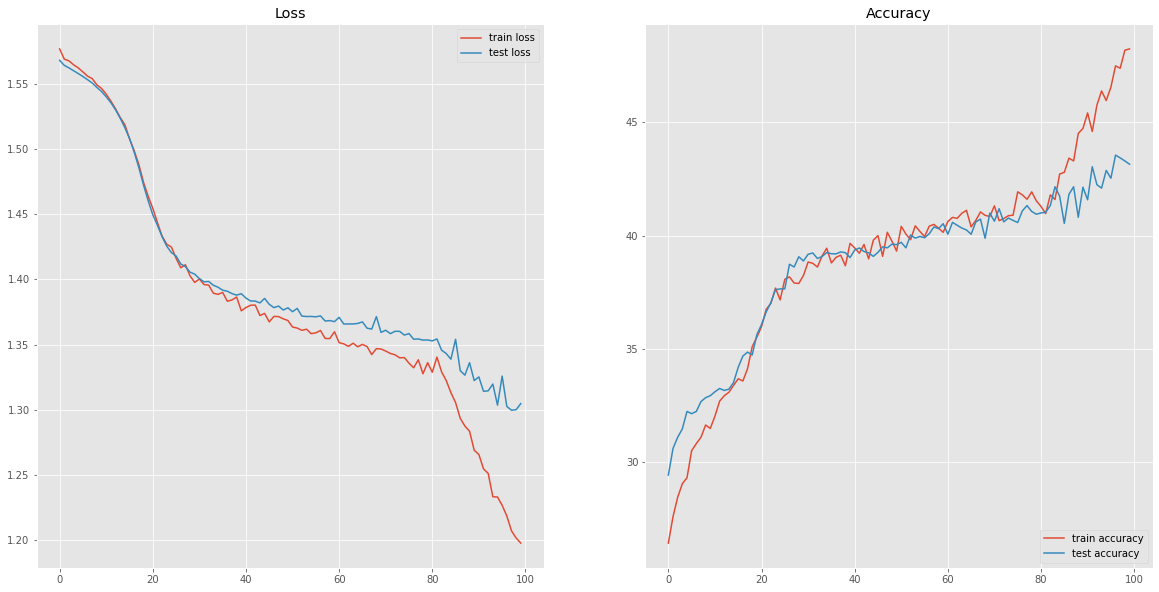

In [55]:
plt.style.use('ggplot')

fig, axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(trn_loss, label = 'train loss')
axs[0].plot(tst_loss, label = 'test loss')
axs[0].legend(loc="upper right")
axs[0].set_title("Loss")

axs[1].plot(trn_acc,  label = 'train accuracy')
axs[1].plot(tst_acc,  label = 'test accuracy')
axs[1].legend(loc="lower right")
axs[1].set_title("Accuracy")

## Validate model results

In [56]:
def test_model(sentence):
  tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
  indexed = [TEXT.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed)
  tensor = tensor.unsqueeze(1).to(device)

  model.eval()
  prediction = model(tensor)

  return( ["very negative", "negative", "neutral", "positive", "very positive"][torch.argmax(prediction, dim=0).item()] )

In [70]:
sentence = test.sentence[111]
sentiment_values = test.sentiment_values[111]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][sentiment_values], sentence

('very negative',
 'negative',
 'Filled with low-brow humor , gratuitous violence and a disturbing disregard for life .')

In [71]:
sentence = test.sentence[221]
sentiment_values = test.sentiment_values[221]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][sentiment_values], sentence

('very negative',
 'very negative',
 "It 's not just the vampires that are damned in Queen of the Damned -- the viewers will feel they suffer the same fate .")

In [73]:
sentence = test.sentence[333]
sentiment_values = test.sentiment_values[333]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][sentiment_values], sentence

('very negative',
 'very negative',
 'The Irwins emerge unscathed , but the fictional footage is unconvincing and criminally badly acted .')

In [74]:
sentence = test.sentence[444]
sentiment_values = test.sentiment_values[444]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][sentiment_values], sentence

('negative',
 'positive',
 'The film is reasonably entertaining , though it begins to drag two-thirds through , when the melodramatic aspects start to overtake the comedy .')

In [76]:
sentence = test.sentence[567]
sentiment_values = test.sentiment_values[567]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][sentiment_values], sentence

('very negative',
 'negative',
 'The film is so packed with subplots involving the various Silbersteins that it feels more like the pilot episode of a TV series than a feature film .')

In [65]:
sentence = test.sentence[611]
sentiment_values = test.sentiment_values[611]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][sentiment_values], sentence

('very negative',
 'negative',
 'Starts out with tremendous promise , introducing an intriguing and alluring premise , only to fall prey to a boatload of screenwriting cliches that sink it faster than a leaky freighter .')

In [66]:
sentence = test.sentence[711]
sentiment_values = test.sentiment_values[711]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][sentiment_values], sentence

('negative',
 'very positive',
 'Gangster No. 1 is solid , satisfying fare for adults .')

In [67]:
sentence = test.sentence[811]
sentiment_values = test.sentiment_values[711]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][sentiment_values], sentence

('very negative',
 'very positive',
 "Showtime is n't particularly assaultive , but it can still make you feel that you never want to see another car chase , explosion or gunfight again .")

In [68]:
sentence = test.sentence[911]
sentiment_values = test.sentiment_values[711]
test_model(sentence), ["very negative", "negative", "neutral", "positive", "very positive"][sentiment_values], sentence

('negative',
 'very positive',
 "The comic performances are all spot on , especially Lee Ross 's turn as Ken .")